# Singular Value Decomposition (SVD) for Image Compression

## Goal of Image Compression
Image compression aims to reduce the amount of data required to represent an image while preserving as much visual information as possible. By leveraging the mathematical properties of matrices, we can approximate an image with fewer components, significantly reducing storage requirements.

### You Can Use SVD for Image Compression
- **Singular Values**:
  - The largest singular values contribute the most to the visual quality of the image.
  - Discarding smaller singular values removes less important details.

---

## SVD Basics
Singular Value Decomposition (SVD) factorizes a matrix into three components:
$$
A = U \Sigma V^\top
$$
Where:
- **$A$**: Original matrix (e.g., pixel intensity values of the image).
- **$U$**: Left singular vectors (column space).
- **$\Sigma$**: Singular values (diagonal matrix with decreasing values representing importance).
- **$V^\top$**: Right singular vectors (row space).

---

## Steps for Image Compression
1. **Decompose the Image Matrix**:
   - First, create an image matrix $A$ and apply SVD to it:
     $$
     A = U \Sigma V^\top
     $$

2. **Truncate the Decomposition**:
   - Retain only the top $k$ singular values and corresponding singular vectors:
     $$
     A_k = U_k \Sigma_k V_k^\top
     $$
   - Variables:
     - $U_k$: First $k$ columns of $U$.
     - $\Sigma_k$: Top $k$ singular values (diagonal matrix).
     - $V_k^\top$: First $k$ rows of $V^\top$.

3. **Reconstruct the Compressed Image**:
   - Multiply the truncated components to approximate the original matrix:
     $$
     A_k = U_k \Sigma_k V_k^\top
     $$
   - The reconstructed matrix $A_k$ is a lower-rank approximation of $A$.

4. **Store Fewer Components**:
   - Instead of storing the full $A$, store $U_k$, $\Sigma_k$, and $V_k^\top$, reduces the storage size when $k < \text{min}(m, n)$.




## Get Image Matrix ($A$)

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
original_image = Image.open('Koala.jpg')
gray_image = original_image.convert("L")  # Convert to grayscale for simplicity
image_matrix = np.array(gray_image)


## Single Value Decomposition 

Now that we have our image matrix, we can use the svd numpy function to get the single value decomposition representation of our matrix. Using this, we will reconstruc the image with different numbers of $k$ singlular values. *Lower $k \rightarrow$ Lower Storage Size*

In [77]:
# Perform Singular Value Decomposition (SVD)
U, S, Vt = np.linalg.svd(image_matrix, full_matrices=False)

# Function to reconstruct the image using k singular values
def reconstruct_image(U, S, Vt, k):
    S_k = np.diag(S[:k])  # Keep only the top k singular values
    U_k = U[:, :k]  # Corresponding left singular vectors
    Vt_k = Vt[:k, :]  # Corresponding right singular vectors
    return np.dot(U_k, np.dot(S_k, Vt_k))



## Plotting the Results

Now that we have defined our image reconstruction function, let's test it. We will visualize our results by printing the images for each value of $k$. Also, we will print the number of bytes each image requires.

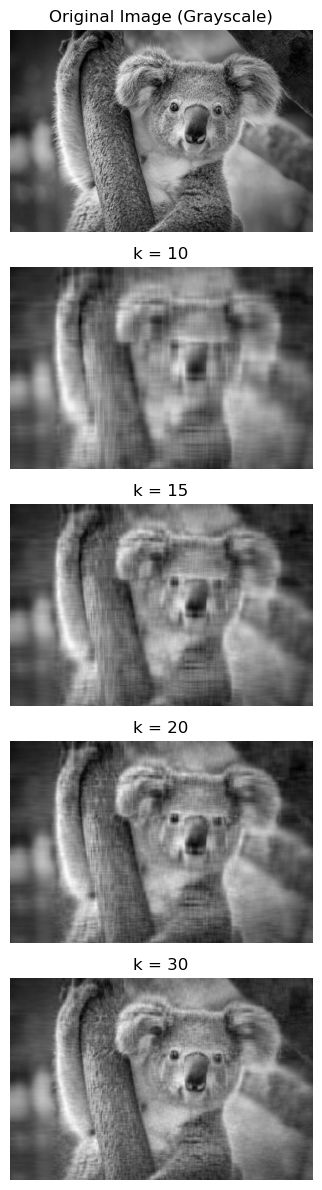

In [83]:
# Plot original and compressed images for various k values
k_values = [10, 15, 20, 30]  # Number of singular values to use for reconstruction
plt.figure(figsize=(8, 12))

# Plot the original grayscale image
plt.subplot(len(k_values) + 1, 1, 1)
plt.title("Original Image (Grayscale)")
plt.imshow(np.array(gray_image), cmap="gray")
plt.axis("off")

# Plot compressed images and print their sizes
for i, k in enumerate(k_values, start=2):
    compressed_image = reconstruct_image(U, S, Vt, k)
    plt.subplot(len(k_values) + 1, 1, i)
    plt.title(f"k = {k}")
    plt.imshow(compressed_image, cmap="gray")
    plt.axis("off")
    
    # Calculate the size of the compressed representation
    size = (U[:, :k].size + S[:k].size + Vt[:k, :].size) * image_matrix.itemsize
    
    # Calculate and print the percentage reduction
    reduction = ((original_size - size) / original_size) * 100

plt.tight_layout()
plt.show()


## Size Reduction Per Image

Looks like our SVD model is doing its job. Now, let's see how much less storage each image takes than the original:

In [79]:
from tabulate import tabulate

# Print the size of the grayscaled version of the original image
original_size = gray_image.size[0] * gray_image.size[1] * image_matrix.itemsize
print(f"Size of grayscaled original image: {original_size} bytes")

# Prepare data for the table
table_data = [["Original", original_size, "N/A"]]

# Plot compressed images and print their sizes
for k in k_values:
    compressed_image = reconstruct_image(U, S, Vt, k)

    # Calculate the size of the compressed representation
    size = (U[:, :k].size + S[:k].size + Vt[:k, :].size) * image_matrix.itemsize
    
    # Calculate the percentage reduction
    reduction = ((original_size - size) / original_size) * 100
    
    # Append data to the table
    table_data.append([f"k={k}", size, f"{reduction:.2f}%"])

# Print the table
print(tabulate(table_data, headers=["Image", "Size (bytes)", "Reduction"]))


Size of grayscaled original image: 282100 bytes
Image       Size (bytes)  Reduction
--------  --------------  -----------
Original          282100  N/A
k=10               10850  96.15%
k=15               16275  94.23%
k=20               21700  92.31%
k=30               32550  88.46%


The image with $k=30$ is pretty good quality all things considered. As ugly as that $k = 10$ image looks, it's impressive how high the reduction in size is (*96%!*). Also, I get the sense that the computer figured out which pixels are more important since the outline of the koala is very noticable compared to the background, especially the right arm, for $k=10$.

## Compressing an Image Without Grayscaling

That was cool, but what if we want our image to retain its color? Let's compress the image without converting it to black-and-white first.

In [80]:
def compress_color_image(image_matrix, k):
    compressed_channels = []
    total_bytes = 0
    for channel in range(3):  # Iterate over the R, G, B channels
        # Perform SVD for the current channel
        U, S, Vt = np.linalg.svd(image_matrix[:, :, channel], full_matrices=False)
        
        # Convert components to float32 for storage efficiency
        U_k = U[:, :k].astype(np.float32)
        S_k = S[:k].astype(np.float32)
        Vt_k = Vt[:k, :].astype(np.float32)
        
        # Calculate compressed size
        total_bytes += U_k.nbytes + S_k.nbytes + Vt_k.nbytes
        
        # Reconstruct the compressed channel
        S_k_diag = np.diag(S_k)
        compressed_channel = np.dot(U_k, np.dot(S_k_diag, Vt_k))
        compressed_channels.append(compressed_channel)
    
    # Stack the compressed channels back into an image
    compressed_image = np.stack(compressed_channels, axis=2)
    return np.clip(compressed_image, 0, 255).astype("uint8"), total_bytes


Image matrix shape: (434, 650, 3)


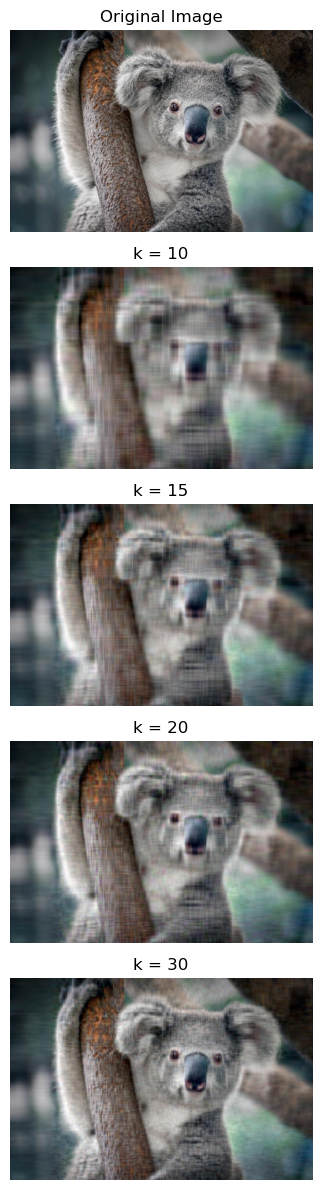

Size of original image: 846300 bytes
Image       Size (bytes)  Reduction
--------  --------------  -----------
Original          846300  N/A
k=10              130200  84.62%
k=15              195300  76.92%
k=20              260400  69.23%
k=30              390600  53.85%


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Ensure the image is in RGB format
if original_image.mode != "RGB":
    original_image = original_image.convert("RGB")

# Convert the image to a NumPy array
image_matrix = np.array(original_image)

# Check the shape of the array
print(f"Image matrix shape: {image_matrix.shape}")  # Should be (height, width, 3)

k_values = [10, 15, 20, 30]
# Plot original and compressed images
plt.figure(figsize=(8, 12))

# Plot the original image
plt.subplot(len(k_values) + 1, 1, 1)
plt.title("Original Image")
plt.imshow(image_matrix)
plt.axis("off")

# Plot compressed images and print their sizes
for i, k in enumerate(k_values, start=2):
    compressed_image, compressed_size = compress_color_image(image_matrix, k)
    plt.subplot(len(k_values) + 1, 1, i)
    plt.title(f"k = {k}")
    plt.imshow(compressed_image)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

# Print the size of the original image
original_size = image_matrix.size * image_matrix.itemsize
print(f"Size of original image: {original_size} bytes")

# Prepare data for the table
table_data = [["Original", original_size, "N/A"]]

# Calculate and print the sizes of the compressed images
for k in k_values:
    compressed_image, compressed_size = compress_color_image(image_matrix, k)
    
    # Calculate the percentage reduction
    reduction = ((original_size - compressed_size) / original_size) * 100
    
    # Append data to the table
    table_data.append([f"k={k}", compressed_size, f"{reduction:.2f}%"])

# Print the table
print(tabulate(table_data, headers=["Image", "Size (bytes)", "Reduction"]))


## Results of Colored Compression Test

As expected, we get a sizable reduction when reducing the colored images, too. This reduction is a lot less than in the grayscale images, since all the compressed images have color now, and so there are many more values to track. Even so, we get some pretty good results!

## In Conclusion

When we decrease $k$ (the number of singular values we retain), the images get blurrier, but the overall shape of the image stays similar. Also, the higher k, the less storage our compressed image takes. 

Even though our images are blurry at low $k$, the point is that the *important* pixel clusters are retained; the model does not remove pixels at random. As a final test, let's see what happens when we use $k=1$.

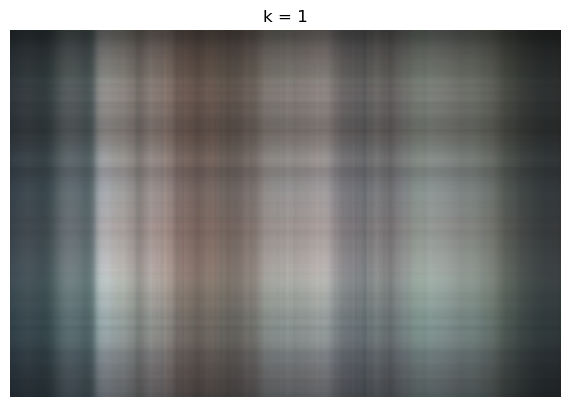

Size of original image: 846300 bytes
Image       Size (bytes)  Reduction
--------  --------------  -----------
Original          846300  N/A
k=1                13020  98.46%


In [92]:
# Set k to 1
k = 1

plt.figure(figsize=(8, 8))

# Compressed image with k=1
compressed_image, compressed_size = compress_color_image(image_matrix, k)
plt.subplot(2, 1, 2)
plt.title(f"k = {k}")
plt.imshow(compressed_image)
plt.axis("off")

plt.tight_layout()
plt.show()

# Calculate original image size
original_size = image_matrix.size * image_matrix.itemsize
print(f"Size of original image: {original_size} bytes")

# Calculate and print size and reduction
reduction = ((original_size - compressed_size) / original_size) * 100
table_data = [
    ["Original", original_size, "N/A"],
    [f"k={k}", compressed_size, f"{reduction:.2f}%"]
]

# Print results as a table
print(tabulate(table_data, headers=["Image", "Size (bytes)", "Reduction"]))

## Why is there a Plaid effect for $k=1$?

The "plaid" effect in SVD-based image compression at $ k = 1 $ occurs because we approximated our matrix $A$ to a rank-1 matrix: 
- $A_1 = \sigma_1 \cdot u_1 \cdot v_1^T$
- Where: 
  - $ \sigma_1 $: The largest singular value (dominant structure).
  - $ u_1 $: Left singular vector (row-wise feature).
  - $ v_1^T $: Right singular vector (column-wise feature).


This rank-1 approximation creates a matrix where pixel values are determined by the outer product of $u_1$ and $v_1^T$, scaled by $\sigma_1$, which results in smooth gradients across rows and columns, creating a **grid-like (plaid) pattern**. The higher singular values that represent finer details are gone. 

Since we did this for a colored image, the rank-1 approximation is applied to each of the R, G, and B channels seperately, and so when they overlap it creates a nice plaid pattern.
